In [1]:
using LinearAlgebra
using Distributions
using Plots
using Random

In [2]:
function polynomialfit(x, y, d)
    X = x .^ (0:d)'
    β̂ = X \ y   
    f(x) = evalpoly(x, β̂)
    ŷ = f.(x)
    r = ŷ - y
    σ = norm(r)
    dist = product_distribution([Normal(μ, σ) for μ in ŷ])
    loglik = logpdf(dist, y)
    AIC = -2loglik + 2(d + 2)
    (; x, y, d, X, β̂, f, ŷ, r, σ, dist, loglik, AIC)
end

function plotpolyfit(result; legend=:topleft, titlefontsize=10, kwargs...)
    (; x, y, d, f, loglik, AIC) = result
    xs = range(extrema(x)...; length=1000)
    plot(; legend, titlefontsize)
    scatter!(x, y; label="data")
    plot!(xs, f.(xs); label="degree-$d fitting")
    title!("degree = $d,  log likelihood = $(round(loglik; digits=2)),  AIC = $(round(AIC; digits=2))")
    plot!(; kwargs...)
end

plotpolyfit (generic function with 1 method)

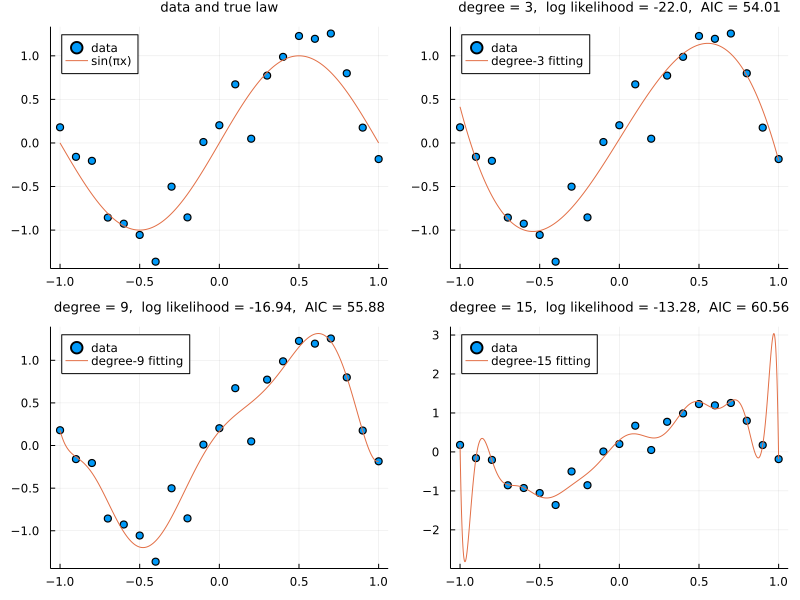

In [3]:
rng = MersenneTwister(1234567890)

x = range(-1, 1; length=21)
noise = 0.3randn(rng, length(x))
y = sinpi.(x) + noise

xs = range(extrema(x)...; length=1000)
P = plot(; legend=:topleft)
scatter!(x, y; label="data")
plot!(xs, sinpi.(xs); label="sin(πx)")
title!("data and true law"; titlefontsize=10)

Q = plotpolyfit(polynomialfit(x, y, 3))
R = plotpolyfit(polynomialfit(x, y, 9))
S = plotpolyfit(polynomialfit(x, y, 15))

plot(P, Q, R, S; size=(800, 600), layout=(2, 2), titlefontsize=9)

対数尤度(log likelihood)の大きさは「もっともらしさ」の度合いではない！

対数尤度の大きさはモデルのデータへのフィッティングの良さの指標の1つに過ぎない。

上の結果を見れば分かるように、フィッティングで使う多項式の次数を上げた方がフィッティングの度合いが上がって、対数尤度も大きくなるが、次数が大きな場合の結果は全然「もっともらしい」とは言えない。

尤度を最大化することによってモデルのパラメータ値を調節する最尤法は「最も尤もらしいパラメータ値」を探すのではなく、単に「モデルをデータに最もフィットさせるようなパラメータ値」を探しているだけである。

最尤法は「最も尤もらしいパラメータ値」を探す方法ではない！

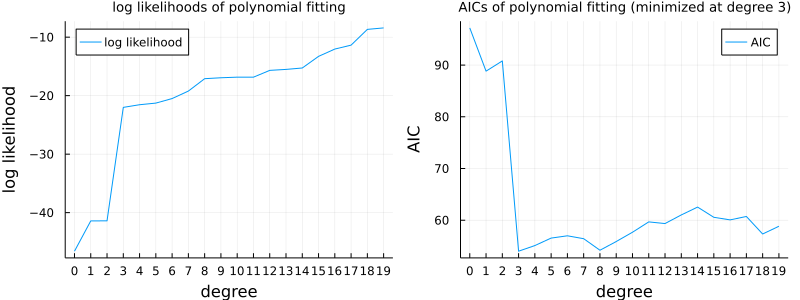

In [4]:
result = polynomialfit.(Ref(x), Ref(y), 0:19)
d = getproperty.(result, :d)
loglik = getproperty.(result, :loglik)
AIC = getproperty.(result, :AIC)
dbest = d[argmin(AIC)]

T = plot(d, loglik; label="log likelihood", legend=:topleft)
plot!(; xtick=d, xlabel="degree", ylabel="log likelihood")
title!("log likelihoods of polynomial fitting"; titlefontsize=10)

U = plot(d, AIC; label="AIC", legend=:topright)
plot!(; xtick=d, xlabel="degree", ylabel="AIC")
title!("AICs of polynomial fitting (minimized at degree $dbest)"; titlefontsize=10)

plot(T, U; size=(800, 300), titlefontsize=9, leftmargin=3Plots.mm, bottommargin=3Plots.mm)